# To include supervised ML, I'll try to build a model to predict vote averages using Random Forest 

In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
import pickle
import joblib
import seaborn as sns


In [81]:
# Load the dataset with NLP features
movies = pd.read_csv('../data/movies_with_nlp.csv')
print(f"Dataset shape: {movies.shape}")
print(f"Columns: {movies.columns.tolist()}")

Dataset shape: (4940, 16)
Columns: ['budget', 'id', 'original_language', 'revenue', 'runtime', 'title', 'vote_average', 'vote_count', 'top_cast', 'director', 'genres', 'keywords', 'release_year', 'profit', 'decade', 'nlp']


In [82]:
# Convert string columns back to lists
for col in ['genres', 'top_cast', 'keywords']:
    if col in movies.columns:
        movies[col] = movies[col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

In [83]:
movies.head(1)

,budget,id,original_language,revenue,runtime,title,vote_average,vote_count,top_cast,director,genres,keywords,release_year,profit,decade,nlp
0,30000000.0,862,en,373554033.0,81.0,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...",1995,343554033.0,1990,toy_story animation comedy family tom_hanks ti...


In [84]:
# Limiting features before encoding to reduce dimensionality
# Keywords - limiting to 100 most common
all_keywords = pd.Series([kw for kws in movies['keywords'] for kw in kws])
top_keywords = all_keywords.value_counts().head(100).index
movies['keywords_filtered'] = movies['keywords'].apply(
    lambda kws: [kw for kw in kws if kw in top_keywords]
)

# Actors - limiting to 100 most common
all_actors = pd.Series([actor for cast in movies['top_cast'] for actor in cast])
top_actors = all_actors.value_counts().head(100).index
movies['top_cast_filtered'] = movies['top_cast'].apply(
    lambda cast: [actor for actor in cast if actor in top_actors]
)

# Directors - limiting to 50 most common
top_directors = movies['director'].value_counts().head(50).index
movies['director_filtered'] = movies['director'].apply(
    lambda d: d if d in top_directors else 'Other'
)

# I will be skipping genres as they are already limited


In [85]:
print(f"Top keywords: {len(top_keywords)}")
print(f"Top actors: {len(top_actors)}")
print(f"Top directors: {len(top_directors)}")

Top keywords: 100
Top actors: 100
Top directors: 50


In [86]:
# Encoding features
# Genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(movies['genres'])
print(f"Genres encoded shape: {genres_encoded.shape}")

# Keywords
mlb_keywords = MultiLabelBinarizer()
keywords_encoded = mlb_keywords.fit_transform(movies['keywords_filtered'])
print(f"Keywords encoded shape: {keywords_encoded.shape}")

# Top Cast
mlb_cast = MultiLabelBinarizer()
cast_encoded = mlb_cast.fit_transform(movies['top_cast_filtered'])
print(f"Cast encoded shape: {cast_encoded.shape}")

# Director (one-hot encoding)
director_encoded = pd.get_dummies(movies['director_filtered']).values
print(f"Director encoded shape: {director_encoded.shape}")

# Language (one-hot encoding)
language_encoded = pd.get_dummies(movies['original_language']).values
print(f"Language encoded shape: {language_encoded.shape}")


Genres encoded shape: (4940, 20)
Keywords encoded shape: (4940, 100)
Cast encoded shape: (4940, 100)
Director encoded shape: (4940, 51)
Language encoded shape: (4940, 36)


In [87]:
# Scaling numerical features
num_features = ['budget', 'revenue', 'runtime', 'profit', 'release_year']
available_num_features = [col for col in num_features if col in movies.columns]
print(f"Available numerical features: {available_num_features}")

scaler = StandardScaler()
num_encoded = scaler.fit_transform(movies[available_num_features])
print(f"Numerical features encoded shape: {num_encoded.shape}")

Available numerical features: ['budget', 'revenue', 'runtime', 'profit', 'release_year']
Numerical features encoded shape: (4940, 5)


In [88]:
X = np.hstack([
    genres_encoded,
    keywords_encoded,
    cast_encoded,
    director_encoded,
    language_encoded,
    num_encoded 
])

In [89]:
# First I'll convert continuous ratings to categories to be used with RandomForestClassifier
def categorize_ratings(rating):
    if rating > 7:
        return 'Good'
    elif rating >= 5:
        return 'Average'
    else:
        return 'Poor'

In [90]:
# Creating categorical target variable to use for my dependent variable
movies['rating_category'] = movies['vote_average'].apply(categorize_ratings)
y = movies['rating_category']

In [91]:
print("Rating distribution:")
print(y.value_counts())
print(f"\nRating percentages:")
print(y.value_counts(normalize=True) * 100)

Rating distribution:
rating_category
Average    3723
Good        921
Poor        296
Name: count, dtype: int64

Rating percentages:
rating_category
Average    75.364372
Good       18.643725
Poor        5.991903
Name: proportion, dtype: float64


In [92]:
# Splitting the data into training and test sets
size = 0.25
seed = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=size, random_state=seed, stratify=y
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (3705, 312), Test set: (1235, 312)


In [93]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    class_weight='balanced',
)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, random_state=42)

In [94]:
# Make predictions
rf_y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
rf_acc = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
print("\nRandom Forest Confusion Matrix:")
print(rf_cm)

# Classification Report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

Random Forest Accuracy: 0.6980

Random Forest Confusion Matrix:
[[723 125  83]
 [117 111   2]
 [ 45   1  28]]

Random Forest Classification Report:
              precision    recall  f1-score   support

     Average       0.82      0.78      0.80       931
        Good       0.47      0.48      0.48       230
        Poor       0.25      0.38      0.30        74

    accuracy                           0.70      1235
   macro avg       0.51      0.55      0.52      1235
weighted avg       0.72      0.70      0.71      1235



In [95]:
# Cross-validation
rf_cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')
print(f"Random Forest CV scores: {rf_cv_scores}")
print(f"Random Forest Mean CV accuracy: {rf_cv_scores.mean():.4f}")

Random Forest CV scores: [0.63360324 0.63765182 0.6791498  0.69230769 0.71862348]
Random Forest Mean CV accuracy: 0.6723


In [96]:
genre_names = [f"genre_{g}" for g in mlb_genres.classes_]
keyword_names = [f"keyword_{k}" for k in mlb_keywords.classes_]
cast_names = [f"cast_{c}" for c in mlb_cast.classes_]

# Use the filtered director data that was actually used for encoding
director_names = [f"director_{d}" for d in pd.get_dummies(movies['director_filtered']).columns]
language_names = [f"lang_{l}" for l in pd.get_dummies(movies['original_language']).columns]
num_names = available_num_features  

# Combine all feature names in the same order as np.hstack
all_feature_names = (
    genre_names +
    keyword_names +
    cast_names +
    director_names +
    language_names +
    num_names
)

print(f"Total features: {len(all_feature_names)}")

Total features: 312


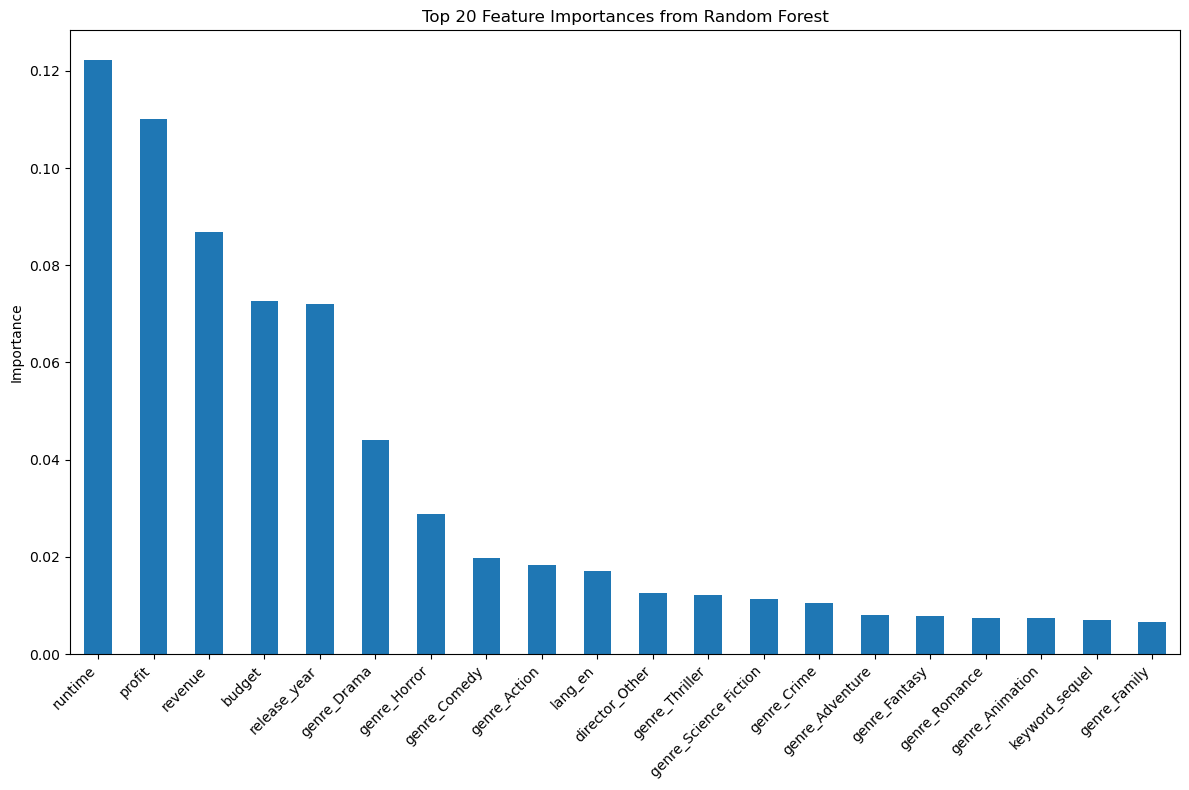

Top 10 most important features:
runtime         0.122238
profit          0.110157
revenue         0.086790
budget          0.072595
release_year    0.072007
genre_Drama     0.043995
genre_Horror    0.028919
genre_Comedy    0.019733
genre_Action    0.018392
lang_en         0.017133
dtype: float64


In [97]:
# Plot feature importances
rf_importances = pd.Series(
    rf_classifier.feature_importances_,
    index=all_feature_names
).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
rf_importances.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(rf_importances.head(10))

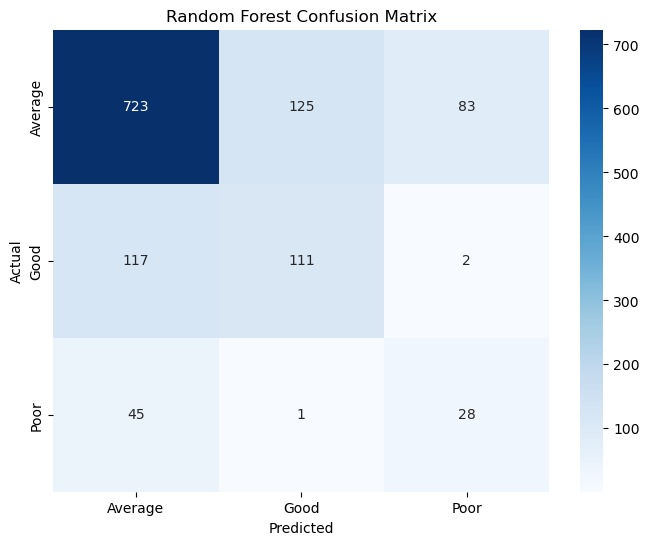

In [100]:
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Average', 'Good', 'Poor'], 
            yticklabels=['Average', 'Good', 'Poor'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [101]:
joblib.dump(rf_classifier, '../models/random_forest.joblib')

['../models/random_forest.joblib']

In [102]:
preprocessing_objects = {
    'mlb_genres': mlb_genres,
    'mlb_keywords': mlb_keywords,
    'mlb_cast': mlb_cast,
    'scaler': scaler,
    'top_keywords': top_keywords,
    'top_actors': top_actors,
    'top_directors': top_directors,
    'director_categories': pd.get_dummies(movies['director_filtered']).columns,
    'language_categories': pd.get_dummies(movies['original_language']).columns,
    'num_features': available_num_features
}

joblib.dump(preprocessing_objects, '../models/rf_preprocessing.joblib')

['../models/rf_preprocessing.joblib']

In [104]:
# Function to test the model 
def test_prediction(movie_idx=0):
    """Test prediction on a sample movie"""
    sample_movie = movies.iloc[movie_idx]
    
    print(f"Testing prediction for: {sample_movie['title']}")
    print(f"Actual rating: {sample_movie['vote_average']}")
    print(f"Actual category: {sample_movie['rating_category']}")
    
    # Get prediction
    sample_X = X[movie_idx:movie_idx+1]
    prediction = rf_classifier.predict(sample_X)[0]
    probabilities = rf_classifier.predict_proba(sample_X)[0]
    
    print(f"Predicted category: {prediction}")
    print("Prediction probabilities:")
    for i, class_name in enumerate(rf_classifier.classes_):
        print(f"  {class_name}: {probabilities[i]:.3f}")

In [107]:
# Testing on a few movies
for i in [42, 112, 777]:
    test_prediction(i)
    print("-" * 50)

Testing prediction for: Boomerang
Actual rating: 5.4
Actual category: Average
Predicted category: Average
Prediction probabilities:
  Average: 0.597
  Good: 0.229
  Poor: 0.174
--------------------------------------------------
Testing prediction for: Tank Girl
Actual rating: 5.5
Actual category: Average
Predicted category: Average
Prediction probabilities:
  Average: 0.473
  Good: 0.069
  Poor: 0.459
--------------------------------------------------
Testing prediction for: Tales from the Darkside: The Movie
Actual rating: 5.8
Actual category: Average
Predicted category: Poor
Prediction probabilities:
  Average: 0.414
  Good: 0.114
  Poor: 0.471
--------------------------------------------------
